# **AN2DL** - Image segmentation challenge

* **Colombo** Filippo - 10559531
* **Del Vecchio** Giovanni - 10570682


## Report

### Preview
For the challenge we have chosen to concentrate ourselves on BipBip images.
The folder contains three notebooks that has been divided for the sake of simplicity of explanation: 
* `1_Preprocessing` (this notebook), that contains basic operations for loading data and process images and the associated masks;
* `2_U-Net`, that contains the code to implement a CNN for segmentation that is inspired by the U-Net architecture; 
* `3_Patching-Augmentation`, that contains the code to train the network patch-wise instead of the full-image resolution way, and to perform data augmentation on the training samples.  

### Preprocessing
Here we load the dataset, and we set up the workspace including the scripts that are provided to read RGB masks and create the RLE encoding to perform the submissions on Codalab.  
In this notebook we also visualize the images and masks of the dataset, but most important, starting from the example seen during lectures, we built a class able to create a dataset that will be used to train the network.

### U-Net
In this notebook we implement a U-Net like network for segmentation. Here there are functions that build the single blocks of the U-Net architecture: 
*   `DownsamplingBlock()`, that provides a single block of the encoder part of the overall network, defining a set of convolutional and max pooling layers;
*   `UpsamplingBlock()`, that instead provides a single block of the decoder part of the overall network, performing concatenations and transpose convolutions;
*   `BottleneckBlock()`, that is used to connect together encoder and decoder.  

We start our experiment using less number of activation maps than the one used in the original paper, and then we increase the complexity adding more filters and some regularization technique to deal with overfitting.  
Initially we start training the network using the full-image resolution.  
Since the classes of the problem are not balanced, we try to implement an alternative loss function to the `SparseCategoricalCrossentropy`: the _Focal Loss_. This loss provides a way to give more importance to the foreground classes with respect to the background, because it tries to handle the class imbalance problem by assigning more weights to hard or easily misclassified examples and to down-weight easy examples.

### Patching and Data augmentation
In this notebook we implement the code needed to train the network patch-wise instead of the full-image resolution way.  
We choose to follow this other way to train the network in order to try to capture more fine-grained detail of the input images, in particular details related to the weed class.  
Since we focused our work only on one team dataset (Bipbip), we need to properly set up a data augmentation procedure in order to deal with the fact that the number of training samples is limited. To do so, through the `augment_dihedral` function we implemented, we flip and rotate the input images to create new training samples.  
This affects the computational time to train the network, but increases the overall performance.


### Conclusion
We performed several experiments, each of them increasing the level of complexity of the network trying to achieve better results.
Among all our experiments, the most important aspects that allowed us to improve our model are stated below:

*   move from a fixed learning rate to an adaptive one, through the `ReduceLROnPlateau` callback. Thanks to this achievement the network was able to limit the oscillation behavior when approaching to an optimal solution;
*   increase the starting filter size of the U-Net architecture (we move from 16 filters (3x3) to 32) and the introduction of a `BatchNormalization` layer after each convolutional one;
*   add a `Dropout` layer in each down-sampling and up-sampling block to control the overfitting;
*   increase the number of training samples through our data augmentation procedure.

Here instead there are other experiments that we tried but does not improve the overall performances.
*   In order to catch more fine-grained detail we implement a patch-wise training procedure, but we obtained the best result when training the network with the full image resolution, probably because of the time expensiveness of the technique and the low number of training epochs performed.
*   To face the same problem, we also tried to decrease the number of convolutional layer in each down-sampling block in order to keep the receptive field as large as possible, to have more detail about the weed class when performing the up-sampling through concatenation and transpose convolution.  
Also in this case we do not improve the performances of the model: the standard U-Net architecture performs better.
*   For class imbalances we implemented the Focal Loss as a weighted loss function for the training of the network.  
Despite this modification, we achieved our best result using the standard `SparseCategoricalCrossentropy`.


# Data import and preprocessing

In [ ]:
from google.colab import drive
import os
from zipfile import ZipFile
drive.mount('/content/drive')

Mounted at /content/drive


**How to organized data and folder to run the notebook** 
```
./drive/MyDrive/
└── ANN_project2
    ├── dataset.zip
    └── starting_kit
        ├── decode_rle_example.py
        ├── prepare_submission.py
        ├── read_mask_example.py
        ├── rgb_mask_example.png
        ├── RGBtoTarget.txt
        └── predictions
            └── rgb_mask_example.png
```
*N.B.*: Some of the files above have been modified to integrate their functions in our notebooks.

## Download the dataset from Codalab

In [ ]:
import requests
#set the condition at true to dowload the dataset from codalab and run the cell
DOWNLOAD = False
if DOWNLOAD:
  if not os.path.exists('./drive/MyDrive/ANN_project2'):
    os.mkdir('./drive/MyDrive/ANN_project2')
  os.chdir('./drive/MyDrive/ANN_project2')
  url = 'https://competitions.codalab.org/my/datasets/download/29a85805-2d8d-4701-a9ab-295180c89eb3'
  r = requests.get(url, allow_redirects=True)
  open('dataset.zip', 'wb').write(r.content)
  print('Download completed.')
else:
  print('Download skipped.')

## Set up of the dependeces

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ANN_project2/starting_kit')

from prepare_submission import *
from read_mask_example import * 
from decode_rle_example import *

import tensorflow as tf
import numpy as np
from datetime import datetime

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Set the seed for random operations. 
SEED = 1234
tf.random.set_seed(SEED)

In [ ]:
#Definitions of constants
drive_root_folder = '/content/drive/MyDrive/ANN_project2/'
apply_data_augmentation = True
IMG_W, IMG_H = 2048, 1536
batch_size = 1

## Load the dataset

In [ ]:
if not os.path.exists('Development_Dataset'):
  with ZipFile('./drive/MyDrive/ANN_project2/dataset.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
print('The dataset is loaded.')

The dataset is loaded.


In [ ]:
cwd = os.getcwd()

Define the `ImageDataGenerator`

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - this class is an adaptation of the one shown in the exercise session: 
      here we do not use txt files to split the train and validation set.
      
  """

  def __init__(self, dataset_dir_list, which_subset, seed=1234, valid_perc=0.2, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    
    self.subset_filenames=[]
    for dataset_dir in dataset_dir_list:
      #get all the filenames
      path = dataset_dir
      #single filename list
      l = os.listdir(os.path.join(path, 'Images'))
      l = list(map(lambda x: x[:-4], l))
      #print(l)
      #get the train test split
      pos_train, pos_valid = train_test_split(range(len(l)), test_size = valid_perc, random_state=seed)
      sel_pos= pos_train if which_subset == 'training' else pos_valid
      for pos in sel_pos:
        self.subset_filenames.append((dataset_dir, l[pos]))

    self.which_subset = which_subset
    self.dataset_dir_list = dataset_dir_list
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(curr_filename[0], 'Images', curr_filename[1] + '.jpg'))
    #mask = Image.open(os.path.join(curr_filename[0], 'Masks', curr_filename[1] + '.png'))
    

    # Resize image and mask
    img = img.resize(self.out_shape)
    #mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    mask_arr = read_rgb_mask(os.path.join(curr_filename[0], 'Masks', curr_filename[1] + '.png'), out_shape=self.out_shape)
    
    img_arr = np.array(img)
    #mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
#custom preprocessing function
def normalize(x):
  x_ = x / 255.0
  return x_

In [ ]:
dir1 = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip', 'Haricot')
dir2 = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip', 'Mais')

dataset = CustomDataset([dir1, dir2], 
                        'training',
                        seed = SEED,
                        valid_perc=0.2,
                        img_generator=img_data_gen,
                        mask_generator=mask_data_gen,
                        out_shape=[IMG_W, IMG_H],
                        preprocessing_function=None)

dataset_valid = CustomDataset([dir1, dir2], 
                        'validation',
                        seed = SEED,
                        valid_perc=0.2,
                        img_generator=img_data_gen,
                        mask_generator=mask_data_gen,
                        out_shape=[IMG_W, IMG_H],
                        preprocessing_function=None)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([IMG_H, IMG_W, 3], [IMG_H, IMG_W, 1]))

train_dataset = train_dataset.batch(batch_size=batch_size)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([IMG_H, IMG_W, 3], [IMG_H, IMG_W, 1]))

valid_dataset = valid_dataset.batch(batch_size=batch_size)
valid_dataset = valid_dataset.repeat()

### Visualization of some samples
Test the setup and check if the generator works as expected.

Define some helper functions that will be used to explore input images and prediction results.

In [ ]:
def mask_to_img(mask):
  colors = {
      'background': [0, 0, 0],
      'crop': [255, 255, 255],
      'weed': [216, 67, 82]
  }
  mask = np.squeeze(mask, axis=2)
  mask_img = np.zeros([mask.shape[0], mask.shape[1], 3])
  mask_img[np.where(mask == 0)] = colors['background']
  mask_img[np.where(mask == 1)] = colors['crop']
  mask_img[np.where(mask == 2)] = colors['weed']
  return mask_img

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list, is_exploration=False, figsize = (15,15)):
  plt.figure(figsize=figsize)

  title = ['Input Image', 'True Mask' , 'Predicted Mask']
  if is_exploration:
    title = title[:-1]
  elif len(display_list) == 2:
    title = title[[0,2]]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 0:
      img = display_list[i]
    else:
      img = mask_to_img(display_list[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.axis('off')  

  plt.show()

def show(model=None, dataset=None, num=1, image_path=None, figsize = (15,15)):
  if dataset:
    for image, mask in dataset.take(num):
      if model:
        pred_mask = model.predict(image)
        image= np.squeeze(image,axis=0)
        mask = np.squeeze(mask, axis=0)
        display([image,
                 mask,
                 create_mask(pred_mask)], is_exploration = False, figsize = figsize)
      else:
        image= np.squeeze(image,axis=0)
        mask = np.squeeze(mask, axis=0)
        display([image, mask], is_exploration = True, figsize = figsize)
  else:
    img = Image.open(image_path)
    img_arr = np.array(img)
    display([img_arr,
             create_mask(model.predict(x=tf.expand_dims(img_arr, 0)))], is_exploration = False, figsize = figsize)

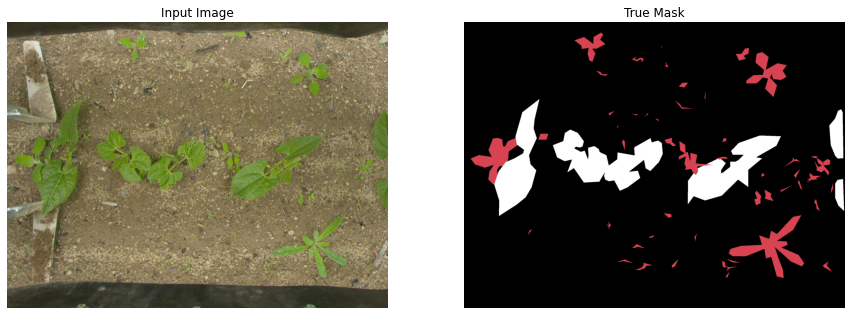

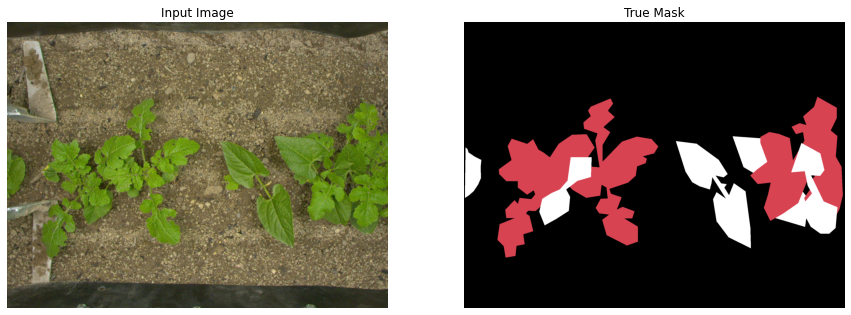

In [ ]:
show(dataset=valid_dataset, num = 2)

# Submission

Here there is the code used to prepare the `.json` file to make the submission.
 

In [ ]:
import os
import json
import numpy as np
from PIL import Image

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def create_json(model, preprocess_function = None):
  team_list = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  crop_list = ['Haricot', 'Mais']

  root_path = 'Development_Dataset/Test_Dev/'
  submission_dict = {}
  for team in team_list:
    for crop in crop_list:
      l = os.listdir(os.path.join(root_path, team, crop, 'Images'))  
      l = list(map(lambda x: x[:-4], l))

      for img_name in l:
        img = None
        try:
          img = Image.open(os.path.join(root_path, team, crop, 'Images', img_name+'.jpg'))
        except:
          img = Image.open(os.path.join(root_path, team, crop, 'Images', img_name+'.png'))
        original_shape = np.array(img).shape
        img = img.resize((IMG_W, IMG_H));
        img_arr = np.array(img)
        if preprocess_function:
          img_arr = preprocess_function(img_arr)
        mask_arr = create_mask(model.predict(x=tf.expand_dims(img_arr, 0))).numpy()

        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = [original_shape[0], original_shape[1]]
        submission_dict[img_name]['team'] = team
        submission_dict[img_name]['crop'] = crop
        submission_dict[img_name]['segmentation'] = {}

        # RLE encoding
        if team == 'Bipbip':
          # crop
          rle_encoded_crop = rle_encode(mask_arr == 1)
          # weed
          rle_encoded_weed = rle_encode(mask_arr == 2)
        else:
          rle_encoded_crop = ''
          rle_encoded_weed = ''

        submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

  # Finally, save the results into the submission.json file

  now = datetime.now().strftime('%b%d_%H-%M-%S')
  out_path = drive_root_folder + 'submission_'+ now +'.json'
  with open(out_path, 'w') as f:
    json.dump(submission_dict, f)
  print(f'{out_path} created.')
  return submission_dict